<h1><center>CMSC320 Final Project:</h1></center>
<h1><center>A Data Science Analysis of Counter Strike: Global Offensive's Professional Circuit</center></h1>
<h2><center>Ashwath Krishnan and Tejas Latupalli</center></h2>

## Introduction

Over the past few years, competitive video games, otherwise known as esports, have become increasingly popular. What began as a cult phenomenon of nerds playing games at their local internet cafe's for a chance to win free food or a couple of bucks in the early 2000s has blossomed into a worldwide sensation that is honestly hard to comprehend. These days, multiple games have reached the level of being able to hold events in large traditional sports arenas like Madison Square Garden and the Oracle Arena. Prize purses for these events routinely break millions of dollars, and the players at the top of these games are treated like celebrities. 

One of the most popular esports titles throughout the 2010s has been Counter Strike: Global Offensive, commonly abbreviated CS:GO, a team-based tactical first-person shooter game played on PC. The game released in 2013, however earlier versions of the game have existed long before that, dating back to as early as 1999. CS:GO has, over its seven year tenure as an esports title, had hundreds of top level tournaments and hundreds of players and teams striving to call themselves the best. In this tutorial, we will go through the full data science pipeline as it relates to CS:GO's professional scene, attempt to answer a couple of questions through exploratory data analysis, and create a machine learning model by which future predictions about players and teams can be made.

More information about CS:GO as a game can be found [here](https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive).

## Environment

The following tutorial will use Python version 3.7.7 and require the following imports:

In [215]:
import pandas as pd
import numpy as np
import datetime
import requests
import re
import math
import os
import _pickle as pickle
from datetime import date, timedelta
from bs4 import BeautifulSoup
from plotnine import *
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

## Data Collection

The primary stats repository for CS:GO is [HLTV](https://hltv.org). They, as a company, have collected data on professional games dating back to the earlier versions of Counter Strike. And ever since late 2015, they have kept a team ranking based on performance over the previous few months. These rankings are the most universally accepted ranking system in the CS:GO community, and are (for the most part) treated as accurate. In addition to these rankings, HLTV has come up with a rating system to simplify all of the factors of a player's performance in a match to just a single number. This rating, commonly known as a player's HLTV rating, accounts for a myriad of factors in the game, including but not limited to, the number of eliminations a player gets in the match, the amount of times the player gets eliminated, the player's clutch plays (1vX scenarios), and how much damage the player is doing to the enemy team as a whole.

One factor that the HLTV rating does not take into account, however, is the skill level of the opposing team. Because of this, there are many players at the top level of the game who seemingly have high ratings, but upon further inspection of their match history, show a history of padding their stats against teams of a significantly lower calibre. I mention this because, looking ahead to the exploratory data analysis section of this tutorial, we will be attempting to answer the question "who is CS:GO's most clutch player", defining clutch as performing when it matters, against the better teams in the world. Keep this in mind as we start to scrape data, as it will be very useful when trying to understand why we are scraping certain things.

First, since we are attempting to see which players perform against the best teams in the world, it makes sense to start by scraping historical ranking data, just so that when we get to scraping match data, we will have an established dataset of what each team was ranked at the time. One mild annoyance of this is that HLTV rankings are published weekly, on mondays, on a separate webpage every time, so we'll need to get crafty with the way we grab this data. First we're going to write a utility function that grabs every monday between the start of HLTV's rankings and 2020. 

You'll notice we've upper bounded the dates in this function to the end of 2019, just because the Covid-19 pandemic made the top level of CS:GO very erratic and unstable throughout 2020.

In [30]:
def all_mondays(year):  # Utility method to fetch all mondays in a given year
    return pd.date_range(start=str(year), end=str(year + 1), freq='W-MON').tolist()

def all_ranking_days():
    days = []
    firstRanking = pd.to_datetime(pd.Timestamp(year=2015, month=10, day=26))
    for i in range(2015, 2020):
        days += all_mondays(i)

    truedays = []
    for day in days:
        d = day.to_pydatetime()
        print(d)
        if d >= firstRanking:
            truedays.append(d)

    return truedays

Next, we have to pay attention to how the URL for each ranking page for each date is formatted, so that we can manipulate the URLs and grab data accordingly. Upon inspection, the way HLTV catelogs the team ranking is following format: hltv.org/ranking/teams/`<YEAR>`/`<MONTH>`/`<DAY>`.

Based on this, we can use our previously defined utility method to generate a list of days we have to get the rankings for, then iterate through those days and insert the date in the above format, use a bit of webscraping magic with BeautifulSoup, and we should be able to get the historical ranking data with minimal issues.

In [31]:
months = {
    1: "january",
    2: "february",
    3: "march",
    4: "april",
    5: "may",
    6: "june",
    7: "july",
    8: "august",
    9: "september",
    10: "october",
    11: "november",
    12: "december"
}

def scrape_rankings():
    days = all_ranking_days() # call utility function to get the ranking days in our range
    rows = []
    for i in range(0, len(days)): # iterate through the days
        day = days[i]
        next_day = days[i + 1] - \
            datetime.timedelta(days=1) if i < len(days) - 1 else date.today()
        # construction of URL
        url = "https://www.hltv.org/ranking/teams/" + \
            str(day.year) + "/" + \
            months[day.month] + "/" + str(day.day)
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        team_list = soup.findAll("div", class_="ranked-team standard-box")
        pattern = re.compile("\#(\d+)")
        res = []
        for team in team_list: # iterate through teams in the week's ranking and get desired fields
            rank = pattern.match(
                team.find("span", class_="position").text).groups(1)[0]
            name = team.find("span", class_="name").text
            players = team.findAll("div", class_="nick")
            playernames = [player.text for player in players]
            date_range = pd.date_range(start=day, end=next_day)
            for d in date_range:
                res.append([d, name, rank, playernames]) # add 1 entry to the final data for every day in that week

        rows += res

    df = pd.DataFrame(data=rows, columns=["date", "name", "rank", "players"])
    return df

One quirk I should mention about the above method is that instead of just saving the ranking for the specific day we scraped it from, we saved the same ranking for every day in that week. This will make things much easier later on, and I just thought I should mention it.

Next, we're gonna make sure the results of this get cached, so that we don't have to run this expensive operation every time we want to test our code or make a change. This doesn't compromise the integrity of our data at all, either, because the stats and rankings from the past are never going to change.

In [32]:
ranking_pickle_filepath = "./data/data.pickle"

if not os.path.exists(ranking_pickle_filepath):
    rankings_df = scrape_rankings()
    rankings_df.to_pickle(ranking_pickle_filepath)
else:
    rankings_df = pd.read_pickle(ranking_pickle_filepath)

rankings_df

,date,name,rank,players
0,2015-10-26,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
1,2015-10-27,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
2,2015-10-28,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
3,2015-10-29,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
4,2015-10-30,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
...,...,...,...,...
46068,2020-05-09,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46069,2020-05-10,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46070,2020-05-11,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46071,2020-05-12,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"


As you can see, it worked! We now have historical ranking data stored in a dataframe. Next, we need information on match data. And since we're focusing on individual player performance, we're going to get our data from the [players section of HLTV](https://www.hltv.org/stats/players). The first step is to set our parameters, since HLTV has data from almost every professional CS:GO match ever played, including obscure semi-professional games. To try and eliminate outliers clouding up our data, we're going to set the match filter to LAN (since results achieved on a LAN setup hold much more weight in the eyes of the community than online games), and set the ranking filter to top 30 teams, as realistically we are looking for a player who has played at the highest level of the game. With these filters factored in, the URL we're going to be using to get the list of players is <https://www.hltv.org/stats/players?matchType=Lan&rankingFilter=Top30>. This link, however, doesn't give us the data we need. For that, we need to scrape individual player stats page URLs from this page, and grab our data from those individual pages (an example page for this would be <https://www.hltv.org/stats/players/7998/s1mple?matchType=Lan&rankingFilter=Top30>). So let's start by defining a method that will scrape the players page and grab the links we need.

In [33]:
players_link = "https://www.hltv.org/stats/players?startDate=all&matchType=Lan&rankingFilter=Top30"

def scrape_player_links():
    page = requests.get(players_link)
    soup = BeautifulSoup(page.content, "html.parser")
    players_table = soup.find(
        "table", class_="stats-table player-ratings-table")
    table_body = players_table.find("tbody")
    player_cells = table_body.findAll("tr")
    player_links = {}
    for player_cell in player_cells:
        player_col = player_cell.find("td", class_="playerCol")
        player_link_tag = player_col.find("a")
        player_link = player_link_tag["href"]
        player_name = player_link_tag.text
        player_links[player_name] = "https://www.hltv.org" + player_link

    return player_links

With that done, we can now look at the format of the individual players' stats page, and get to work on scraping that in a similar fashion to how we got the rankings data. This page is slightly more complex in terms of its formatting, so we'll need to be a bit careful and use some regular expression magic to grab the actual values we need from the table. Let's define a function to do this.

In [34]:
def scrape_player_data(links):
    data = []
    score_pattern = re.compile("\((\d+)\)") # regex pattern that will help a lot with the fields on this page
    kd_pattern = re.compile("(\d+) - (\d+)") # another regex pattern that will help a lot
    for player, link in links.items(): # iterate through each link
        matches_link = link.replace("/players", "/players/matches") # get to the matches page from the player's overview page
        page = requests.get(matches_link)
        soup = BeautifulSoup(page.content, "html.parser")
        stats_table = soup.find("table")
        table_body = stats_table.find("tbody")
        match_rows = table_body.findAll("tr")
        for match_row in match_rows: # go through all the matches the player has on record and pull out the desired fields
            cells = match_row.findAll("td")
            date = cells[0].find("div", class_="time").text.strip()
            team = cells[1].findAll("span")[0].text.strip()
            rounds_text = cells[1].findAll("span")[1].text.strip()
            team_rounds = score_pattern.match(rounds_text).group(1)
            opposing_team = cells[2].findAll("span")[0].text.strip()
            opposing_team_rounds = score_pattern.match(
                cells[2].findAll("span")[1].text.strip()).group(1)
            map_played = cells[3].text.strip()
            kills = kd_pattern.match(cells[4].text.strip()).group(1)
            deaths = kd_pattern.match(cells[4].text.strip()).group(2)
            differential = cells[5].text.strip()
            rating = cells[6].text.strip()
            data.append([player, date, team, team_rounds, opposing_team,
                         opposing_team_rounds, map_played, kills, deaths, differential, rating])

    columns = ["player", "date", "team", "team_rounds", "opposing_team",
               "opposing_team_rounds", "map", "kills", "deaths", "differential", "rating"]
    df = pd.DataFrame(data=data, columns=columns)

    return df

And similar to the rankings data, we're going to cache this data once we have it to save us time and save the wonderful people over at HLTV the cost of serving us these same webpages over and over. 

In [35]:
match_pickle_filepath = "./data/matches.pickle"

if not os.path.exists(match_pickle_filepath):
    player_links = scrape_player_links()
    player_data = scrape_player_data(player_links)
    player_data.to_pickle(match_pickle_filepath)
else:
    player_data = pd.read_pickle(match_pickle_filepath)

player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating
0,s1mple,1/3/20,Natus Vincere,16,G2,2,mrg,14,2,+12,1.57
1,s1mple,1/3/20,Natus Vincere,16,G2,13,d2,26,19,+7,1.35
2,s1mple,1/3/20,Natus Vincere,16,G2,4,nuke,19,8,+11,1.73
3,s1mple,29/2/20,Natus Vincere,16,Astralis,5,nuke,18,11,+7,1.52
4,s1mple,29/2/20,Natus Vincere,16,Astralis,5,d2,25,11,+14,2.09
...,...,...,...,...,...,...,...,...,...,...,...
34268,daps,8/11/15,Conquest,16,Dignitas,9,cbl,18,16,+2,1.13 *
34269,daps,7/11/15,Conquest,22,Liquid,18,cbl,14,32,-18,0.47 *
34270,daps,7/11/15,Conquest,16,Liquid,11,trn,18,18,0,0.94 *
34271,daps,7/11/15,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65 *


And with that, the data collection stage of this tutorial is complete! Next, we need to make some modifications to the data for our use.

## Tidying and Manipulating Our Data

In this step we're going to be making some changes to the format of our data to make it easier for us in the long run and to generate some statistics that HLTV didn't natively provide on the stats page. Let's start with the rankings dataframe, as there is only a single change that needs to be made there. Let's change the format of the date column to be a true Python datetime formatted column, to make working with those dates easier later. After this, since we're done with that dataframe, lets cache it again as a "tidy" version.

In [36]:
tidied_rankings_path = "./data/tidied/rankings.pickle"

if not os.path.exists(tidied_rankings_path):
    rankings_df["date"] = pd.to_datetime(rankings_df["date"], format="%Y-%m-%d")
    rankings_df.to_pickle(tidied_rankings_path)
else:
    rankings_df = pd.read_pickle(tidied_rankings_path)

rankings_df

,date,name,rank,players
0,2015-10-26,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
1,2015-10-27,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
2,2015-10-28,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
3,2015-10-29,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
4,2015-10-30,TSM,1,"[karrigan, cajunb, Xyp9x, dupreeh, device]"
...,...,...,...,...
46068,2020-05-09,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46069,2020-05-10,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46070,2020-05-11,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"
46071,2020-05-12,HAVU,30,"[sAw, ZOREE, sLowi, doto, hoody]"


Before we move on to the player_data dataframe, lets think for a second the main task we're trying to accomplish. Since we're trying to add context about the opposing team's level to each match, we need a way to get the ranking for a specific team during the time of a specific match. Lucky for us, every match we've logged into our dataframe has a "date" parameter, and we separated the weekly rankings into individual days earlier so all we have to do is write a utility function to accomplish this. We'll set the value of unranked teams to be -1, for now.

In [37]:
def get_opponent_rank(opponent, date):
    subset = rankings_df[rankings_df["date"] == date] # get rankings at that date
    if len(subset) == 0:
        return -1
    rows = subset[subset["name"] == opponent]
    if(len(rows) == 0):
        return -1
    row = rows.iloc[[0]]
    if len(row) == 0:
        return -1
    return row["rank"].iloc[0]

Next, we can make all the changes we want to our dataset. Let's start by converting the date column as we did to the rankings dataframe. In the same vein, lets set all the numerical fields to a true numeric format as well.

In addition to just column formatting, we're also going to add the following fields:

* KDR: The kill/death ratio of the player in the specific match, defined as (kills / deaths)
* KPR: The kills per round statistic of the player in the specific match, defined as  (kills / (team rounds + opposing team rounds))
* Win: A logical column defining if the match is a win or loss for the player in question by comparing the rounds his/her team won to the rounds the opposing team won
* Opposing Team Rank: Using the previously defined utility function, we're going to iterate through our dataset and add the ranks of the opponent as a numerical column
* Team Rank: The player's team's rank using the same method defined above
* Rank Differential: The difference in rank between the the two teams (note that if either team is unranked, we're going to treat the differential as infinite)

And finally, we're going to remove all of the matches outside of the range where HLTV has been keeping rankings, just so that we remain consistent. At the end of all of this, we're going to re-cache our dataset, so that we don't have to do this expensive process again between runs.

In [223]:
tidied_player_data_path = "./data/tidied/matches.pickle"

if not os.path.exists(tidied_player_data_path):
    # correct data formats

    player_data["date"] = pd.to_datetime(
        player_data["date"], format="%d/%m/%y")
    player_data["team_rounds"] = pd.to_numeric(player_data["team_rounds"])
    player_data["opposing_team_rounds"] = pd.to_numeric(
        player_data["opposing_team_rounds"])
    player_data["kills"] = pd.to_numeric(player_data["kills"])
    player_data["deaths"] = pd.to_numeric(player_data["deaths"])
    player_data["differential"] = pd.to_numeric(player_data["differential"])
    player_data["rating"] = player_data["rating"].replace(to_replace="\*", value="", regex=True)
    # player_data["rating"] = player_data["rating"].str.strip()

    # adding necessary fields
    player_data["win"] = player_data["team_rounds"] > player_data["opposing_team_rounds"]
    player_data["kdr"] = player_data["kills"] / player_data["deaths"]
    player_data["kpr"] = player_data["kills"] / \
        (player_data["team_rounds"] + player_data["opposing_team_rounds"])

    player_data["opposing_team_rank"] = -1  # just to create the column
    player_data["team_rank"] = -1
    for index, row in player_data.iterrows():
        player_data.at[index, "opposing_team_rank"] = get_opponent_rank(
            row["opposing_team"], row["date"])
        player_data.at[index, "team_rank"] = get_opponent_rank(
            row["team"], row["date"])

    player_data["opposing_team_rank"] = pd.to_numeric(player_data["opposing_team_rank"])
    player_data["team_rank"] = pd.to_numeric(player_data["team_rank"])
    
    player_data["rank_differential"] = player_data.apply(lambda row: 31 if row["team_rank"] == -1 or row["opposing_team_rank"] == -1 else row["opposing_team_rank"] - row["team_rank"], axis=1)

    # filtering matches to fit desired timeframe
    start = pd.to_datetime('2015-10-26')
    end = pd.to_datetime('2019-12-30')
    player_data = player_data.query(
        'date > @start and date < @end').reset_index(drop=True)

    player_data.to_pickle(tidied_player_data_path)

else:
    player_data = pd.read_pickle(tidied_player_data_path)

player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual,top_10,top_10_most_played,features
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5,1.5,1.605,0.535,True,True,NaN
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5,1.5,1.410,0.470,True,True,NaN
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11,1.0,1.420,0.000,True,True,NaN
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11,1.0,1.800,0.000,True,True,NaN
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11,1.0,1.110,0.000,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32666,daps,2015-11-08,Conquest,16,Dignitas,9,cbl,18,16,2,1.13,True,1.125000,0.720000,-1,-1,31,1.0,1.130,0.000,False,False,NaN
32667,daps,2015-11-07,Conquest,22,Liquid,18,cbl,14,32,-18,0.47,True,0.437500,0.350000,-1,-1,31,1.0,0.470,0.000,False,False,NaN
32668,daps,2015-11-07,Conquest,16,Liquid,11,trn,18,18,0,0.94,True,1.000000,0.666667,-1,-1,31,1.0,0.940,0.000,False,False,NaN
32669,daps,2015-11-07,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65,False,0.588235,0.487805,-1,-1,31,1.0,0.650,0.000,False,False,NaN


Much better. 

I think it's time we start thinking about the specific parameters of the question we're trying to solve. We are, in essence, trying to find out which CS:GO players play best at against all levels, not just players who pad their stats against weaker opposition. To do this, we're going to develop an "importance" metric for each match, based on the rank differential between the two teams. We will define this "importance" based on the following piecewise forumula:

<center>y = 1.5 for x < 2</center>
<center>$y = \frac{3}{x + 1} + 0.5$ for 2 <= x <= 5</center>
<center>y = 1 for x >= 5</center>
<center>Where y is the importance of a particular game and x is the rank differential between the teams</center>
    
To explain this a bit, if a team plays against a team higher ranked than them, the game will have an importance rating of 1.5 for the player in question. If a team plays against a team which is lower ranked than them, but is within the range of 2 < x <= 5, some importance will still be given to the game, but on a diminishing scale, as as the higher the differential is, the more we expect the higher ranked team to come out victorius. After the differential crosses 5, the game recieves an importance of 1, as the player in question's team is fully expected to win the match. 
    
Let's use this formula to add a column to our dataframe.

In [224]:
def importance(row):
    if row["rank_differential"] <= 2:
        return 1.5
    elif row["rank_differential"] <= 5:
        return (3 / (row["rank_differential"] + 1) + 0.5)
    else:
        return 1

if importance not in player_data:
    player_data["importance"] = player_data.apply(importance, axis=1)
    player_data.to_pickle(tidied_player_data_path)
    
player_data.head()

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual,top_10,top_10_most_played,features
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5,1.5,1.605,0.535,True,True,NaN
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5,1.5,1.410,0.470,True,True,NaN
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11,1.0,1.420,0.000,True,True,NaN
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11,1.0,1.800,0.000,True,True,NaN
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11,1.0,1.110,0.000,True,True,NaN


Finally, lets create a column called performance, which is the result of multiplying a given match's importance statistic with the player in question's rating during that match. 

In [225]:
player_data["rating"] = pd.to_numeric(player_data["rating"])
player_data["performance"] = player_data["importance"] * player_data["rating"]

player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual,top_10,top_10_most_played,features
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5,1.5,1.605,0.535,True,True,NaN
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5,1.5,1.410,0.470,True,True,NaN
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11,1.0,1.420,0.000,True,True,NaN
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11,1.0,1.800,0.000,True,True,NaN
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11,1.0,1.110,0.000,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32666,daps,2015-11-08,Conquest,16,Dignitas,9,cbl,18,16,2,1.13,True,1.125000,0.720000,-1,-1,31,1.0,1.130,0.000,False,False,NaN
32667,daps,2015-11-07,Conquest,22,Liquid,18,cbl,14,32,-18,0.47,True,0.437500,0.350000,-1,-1,31,1.0,0.470,0.000,False,False,NaN
32668,daps,2015-11-07,Conquest,16,Liquid,11,trn,18,18,0,0.94,True,1.000000,0.666667,-1,-1,31,1.0,0.940,0.000,False,False,NaN
32669,daps,2015-11-07,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65,False,0.588235,0.487805,-1,-1,31,1.0,0.650,0.000,False,False,NaN


In [226]:
player_data["performance_residual"] = player_data["performance"] - player_data["rating"]
player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual,top_10,top_10_most_played,features
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5,1.5,1.605,0.535,True,True,NaN
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5,1.5,1.410,0.470,True,True,NaN
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11,1.0,1.420,0.000,True,True,NaN
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11,1.0,1.800,0.000,True,True,NaN
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11,1.0,1.110,0.000,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32666,daps,2015-11-08,Conquest,16,Dignitas,9,cbl,18,16,2,1.13,True,1.125000,0.720000,-1,-1,31,1.0,1.130,0.000,False,False,NaN
32667,daps,2015-11-07,Conquest,22,Liquid,18,cbl,14,32,-18,0.47,True,0.437500,0.350000,-1,-1,31,1.0,0.470,0.000,False,False,NaN
32668,daps,2015-11-07,Conquest,16,Liquid,11,trn,18,18,0,0.94,True,1.000000,0.666667,-1,-1,31,1.0,0.940,0.000,False,False,NaN
32669,daps,2015-11-07,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65,False,0.588235,0.487805,-1,-1,31,1.0,0.650,0.000,False,False,NaN


And with that, we have successfully prepared our data for the analysis we will be doing in the rest of this tutorial!

## Exploratory Data Analysis

Let's start this section by creating a dataframe of the summarized results of our data.

In [227]:
averages = player_data.groupby(["player"]).mean()

averages.sort_values(by=["performance_residual"], ascending=False).head(20)

,team_rounds,opposing_team_rounds,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual,top_10,top_10_most_played,features
player,,,,,,,,,,,,,,,,,,
jks,12.711048,13.713881,18.110482,17.246459,0.864023,1.068074,0.453258,1.125401,0.680996,11.436261,15.580737,-0.016997,1.334419,1.411895,0.343822,0.0,0.000000,NaN
AZR,12.711048,13.713881,17.396601,18.600567,-1.203966,0.994164,0.453258,0.969954,0.653455,11.436261,15.580737,-0.016997,1.334419,1.323514,0.329350,0.0,0.000000,NaN
jkaem,12.763804,13.641104,18.226994,18.567485,-0.340491,1.061840,0.453988,1.033587,0.686214,10.447853,11.886503,1.987730,1.315644,1.382448,0.320607,0.0,0.199387,NaN
kennyS,13.852525,13.048485,19.943434,16.903030,3.040404,1.149535,0.545455,1.301597,0.744685,9.577778,10.185859,4.339394,1.274444,1.457278,0.307742,1.0,0.000000,NaN
LUCAS1,13.205387,13.296296,17.185185,17.986532,-0.801347,1.039865,0.508418,1.024633,0.650622,10.582492,12.148148,4.033670,1.295960,1.338473,0.298608,0.0,0.000000,NaN
Snappi,12.955017,13.460208,16.280277,18.252595,-1.972318,0.961834,0.467128,0.945710,0.617201,11.058824,15.598616,3.269896,1.316955,1.258450,0.296616,0.0,0.000000,NaN
NiKo,13.856589,12.482558,21.031008,17.368217,3.662791,1.235233,0.562016,1.317454,0.800237,7.990310,5.333333,7.288760,1.238275,1.529391,0.294158,1.0,1.000000,NaN
aizy,13.394068,13.493644,18.129237,17.970339,0.158898,1.069237,0.504237,1.103108,0.675815,9.091102,10.675847,5.298729,1.278284,1.359410,0.290173,0.0,0.201271,NaN
REZ,13.236620,13.352113,18.428169,18.129577,0.298592,1.083437,0.476056,1.080798,0.692235,9.157746,10.614085,5.650704,1.274225,1.369561,0.286124,0.0,0.825352,NaN


With that out of the way, we are free to start graphing some of our findings so that we can get a visual representation. The first thing we are going to graph is the performance rating average for each player vs the player in question's average overall rating. This should give us a better idea of how the two are correlated.

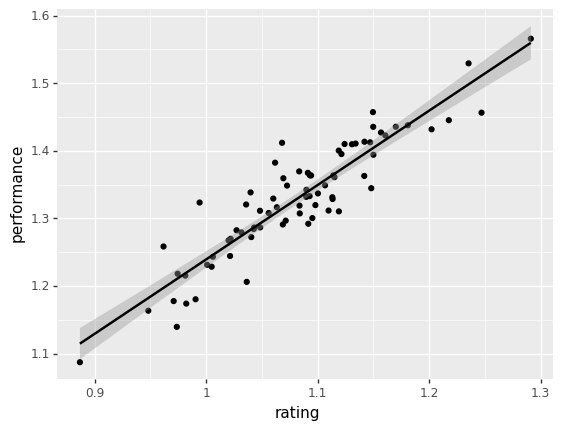

<ggplot: (-9223371876942272340)>

In [228]:
(ggplot(averages, aes(x='rating', y='performance'))
    + geom_point()
    + geom_smooth(method="lm"))

It seems to be a linear relationship, which makes sense. Next, we're going to try and graph the performance of the top 10 performing players over time. We are going to do this by creating a logical column in our dataframe that is set to true if the player is a top 10 performing player of all time.

In [122]:
top_10 = []

subset = player_data.groupby(["player"]).mean().sort_values(by=["performance"], ascending=False).head(8).reset_index()

for index, row in subset.iterrows():
    top_10.append(row["player"])
    
player_data["top_10"] = player_data.apply(lambda row: row["player"] in top_10, axis=1)
player_data

,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual,top_10
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5.0,1.5,1.605,0.535,True
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5.0,1.5,1.410,0.470,True
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11.0,1.0,1.420,0.000,True
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11.0,1.0,1.800,0.000,True
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11.0,1.0,1.110,0.000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32666,daps,2015-11-08,Conquest,16,Dignitas,9,cbl,18,16,2,1.13,True,1.125000,0.720000,-1,-1,inf,1.0,1.130,0.000,False
32667,daps,2015-11-07,Conquest,22,Liquid,18,cbl,14,32,-18,0.47,True,0.437500,0.350000,-1,-1,inf,1.0,0.470,0.000,False
32668,daps,2015-11-07,Conquest,16,Liquid,11,trn,18,18,0,0.94,True,1.000000,0.666667,-1,-1,inf,1.0,0.940,0.000,False
32669,daps,2015-11-07,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65,False,0.588235,0.487805,-1,-1,inf,1.0,0.650,0.000,False


Next, we have to resample our data so that we get the average for players on a 6 month basis. This will give us a rough idea of the ups and downs of certain players over the duration that HLTV has been keeping track of rankings.

In [353]:
new_df = player_data.groupby(["player"]).resample('6M', on="date").mean().sort_values(by=["performance"], ascending=False).reset_index()
new_df["date"] = pd.to_datetime(new_df["date"])

new_df

,player,date,team_rounds,opposing_team_rounds,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual,top_10,top_10_most_played,features
0,aizy,2015-10-31,10.000000,16.0,29.500000,19.000000,10.50,1.5150,0.0,1.536111,1.116667,7.000000,8.0,-1.000000,1.50,2.27250,0.75750,0.0,0.0,NaN
1,apEX,2015-10-31,14.600000,8.4,20.400000,13.800000,6.60,1.3320,0.8,1.569184,0.891636,4.000000,4.0,0.000000,1.42,1.89560,0.56360,0.0,0.0,NaN
2,NBK-,2015-10-31,14.600000,8.4,18.000000,12.200000,5.80,1.2740,0.8,1.781044,0.798747,4.000000,4.0,0.000000,1.42,1.80860,0.53460,0.0,0.0,NaN
3,coldzera,2015-10-31,14.750000,14.0,23.000000,18.750000,4.25,1.1925,0.5,1.294826,0.807439,5.250000,15.0,-9.750000,1.50,1.78875,0.59625,1.0,0.0,NaN
4,CeRq,2017-10-31,10.333333,16.0,22.333333,18.333333,4.00,1.1400,0.0,1.183333,0.826190,24.666667,27.0,-2.333333,1.50,1.71000,0.57000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,felps,2018-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
702,friberg,2017-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
703,stanislaw,2018-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704,suNny,2017-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With that done, we are free to graph!

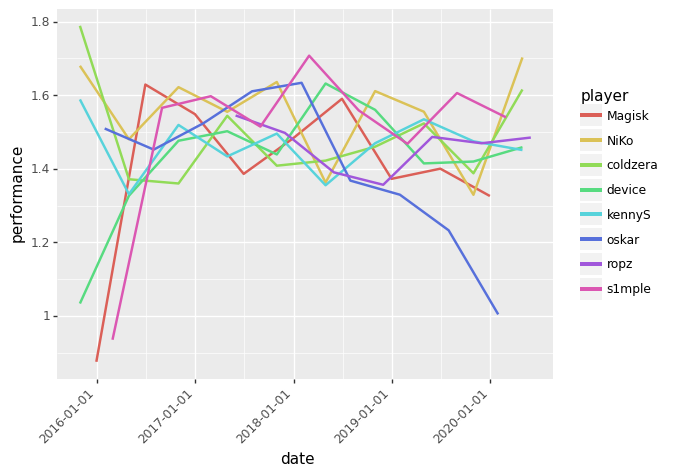

<ggplot: (-9223371876924500396)>

In [354]:
(ggplot(new_df[new_df["top_10"] == True], aes(x="date", y="performance"))
    + geom_line(aes(color="player"), size=1)
    + theme(axis_text_x=element_text(angle=45,hjust=1)))

Key takeaways for this graph is that the highest performing player overall, s1mple, had a period early in his career where his performance rating was actually quite subpar, but he turned it around and had multiple time periods where his performance outranked his peers.

Next, lets look at the performance residual stat: how much a player outperforms their rating by against tougher opposition. Let's graph this against rating to see if there is any correlation between the two.

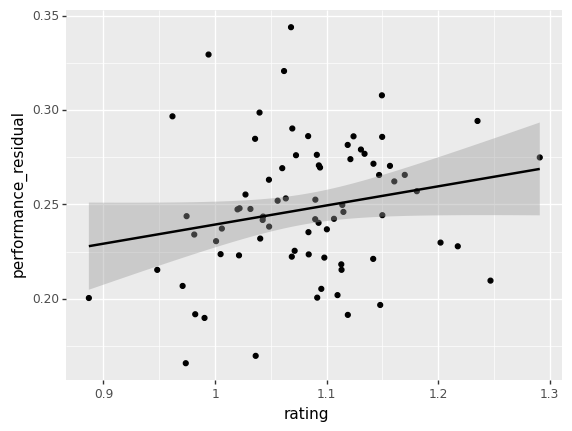

<ggplot: (-9223371876926602684)>

In [355]:
(ggplot(averages, aes(x="rating", y="performance_residual"))
    + geom_point()
    + geom_smooth(method="lm"))

There appears to be a slight positive correlation between the two, but not by any significant amount. It appears that there are underperformers and overperformers all over the rating spectrum.

Next, lets look at kill/death ratio vs average performance.

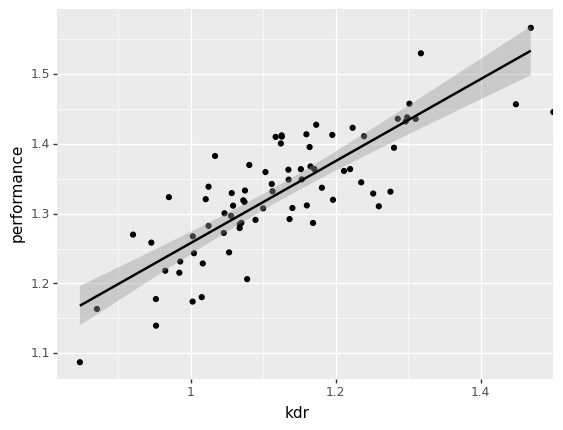

<ggplot: (-9223371876942272068)>

In [230]:
(ggplot(averages, aes(x="kdr", y="performance"))
    + geom_point()
    + geom_smooth(method="lm"))

It appears that the two are definitely correlated in that the players with high average kill/death ratios have high performance metrics. This is expected, as performance is influenced by kill rating.

Finally, lets look at the performance of teams over time using win percentage as our performance metric. We're going to something similar to what we did for the top 10 players, but for teams, we're going to do the teams that have played the most games. This is to see how teams that have been at the top level for a long time have fluctuated over time.

In [235]:
most_played = player_data.groupby("team").count().sort_values(["performance"], ascending=False).head(8).reset_index()

teams = []
for index, row in most_played.iterrows():
    teams.append(row["team"])
    
player_data["top_10_most_played"] = player_data.apply(lambda row: row["team"] in teams, axis=1)

player_data


,player,date,team,team_rounds,opposing_team,opposing_team_rounds,map,kills,deaths,differential,rating,win,kdr,kpr,opposing_team_rank,team_rank,rank_differential,importance,performance,performance_residual,top_10,top_10_most_played,features
0,s1mple,2019-12-21,Natus Vincere,14,Evil Geniuses,16,d2,22,20,2,1.07,False,1.100000,0.733333,5,10,-5,1.5,1.605,0.535,True,True,NaN
1,s1mple,2019-12-21,Natus Vincere,10,Evil Geniuses,16,mrg,16,18,-2,0.94,False,0.888889,0.615385,5,10,-5,1.5,1.410,0.470,True,True,NaN
2,s1mple,2019-12-19,Natus Vincere,16,Heroic,9,inf,21,13,8,1.42,True,1.615385,0.840000,21,10,11,1.0,1.420,0.000,True,True,NaN
3,s1mple,2019-12-19,Natus Vincere,16,Heroic,6,trn,24,10,14,1.80,True,2.400000,1.090909,21,10,11,1.0,1.800,0.000,True,True,NaN
4,s1mple,2019-12-19,Natus Vincere,9,Heroic,16,nuke,20,16,4,1.11,False,1.250000,0.800000,21,10,11,1.0,1.110,0.000,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32666,daps,2015-11-08,Conquest,16,Dignitas,9,cbl,18,16,2,1.13,True,1.125000,0.720000,-1,-1,31,1.0,1.130,0.000,False,False,NaN
32667,daps,2015-11-07,Conquest,22,Liquid,18,cbl,14,32,-18,0.47,True,0.437500,0.350000,-1,-1,31,1.0,0.470,0.000,False,False,NaN
32668,daps,2015-11-07,Conquest,16,Liquid,11,trn,18,18,0,0.94,True,1.000000,0.666667,-1,-1,31,1.0,0.940,0.000,False,False,NaN
32669,daps,2015-11-07,Conquest,19,Virtus.pro,22,inf,20,34,-14,0.65,False,0.588235,0.487805,-1,-1,31,1.0,0.650,0.000,False,False,NaN


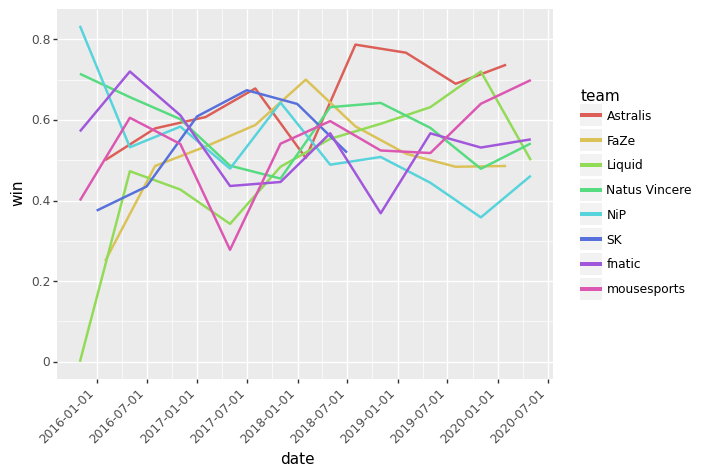

<ggplot: (-9223371876928644212)>

In [301]:
new_df_teams = player_data.groupby(["team"]).resample('6M', on="date").mean().reset_index()
new_df_teams["date"] = pd.to_datetime(new_df_teams["date"])

(ggplot(new_df_teams[new_df_teams["top_10_most_played"] == True], aes(x="date", y="win"))
    + geom_line(aes(color="team"), size=1)
    + theme(axis_text_x=element_text(angle=45,hjust=1)))

Very interesting that while all of these teams

## Machine Learning

With the exploratory data analysis out of the way, we can now use machine learning to try to predict outcomes of matches based on individual player performances. Now, since Counter Strike is a team game, and the whole team's performance contributes to a win or loss, this requires some knowledge of the game and the Counter Strike professional scene in general. For example, predicting the outcome of an Astralis match based on the stats of the player 'Gla1ve' makes no sense, as 'Gla1ve' is the designated in-game-leader, whos job it is to take less favorable positions in favor of setting up the more mechanically skilled players to do well. His job is also to come up with strategies and counter-tactics, which, most of the time, makes his individual play a secondary factor to the match's outcome. Instead, a better judge of a team's performance would be the performance of the star player, whos entire job is to get as many kills as possible while dying as little as possible, to give the team a fighting chance in every round. For Astralis, this would be 'dev1ce'.

To set up a dataframe that is ML-compatible, we have to do some processing on our existing player_data dataframe. Since we want our predictor to be able to take in a player, a map, a rank differential, the player's kills, and the player's deaths, in order to predict the outcome of the game in which those factors occured, we need to create a 'wide' dataframe with those parameters.

In [251]:
player_data.fillna(player_data.mean(), inplace=True) # four or 5 rows had NA for the rating for some reason, so we just replaced them with the mean rating (~1.0)

rows = []
for index, row in player_data.iterrows():
    feature_set = []
    feature_set.append(row["player"])
    feature_set.append(row["kills"])
    feature_set.append(row["deaths"])
    feature_set.append(row["kpr"])
    feature_set.append(row["map"])
    feature_set.append(row["opposing_team"])
    feature_set.append(row["rank_differential"])
    feature_set.append(1 if row["win"] else 0)
    rows.append(feature_set)
    
ml_df = pd.DataFrame(data=rows, columns=["player", "kills", "deaths", "kpr", "map", "opposing_team", "rank_differential", "result"])
ml_df.replace([np.inf, -np.inf], 31)

new_rows = []
for index, row in ml_df.iterrows():
    pset = []
    pset.append(row["player"])
    pset.append(row["opposing_team"])
    pset.append(row["map"])
    pset.append(row["result"])
    pset.append([row["kills"], row["deaths"], row["rank_differential"]])
    new_rows.append(pset)
    
ml_df = pd.DataFrame(data=new_rows, columns=["player", "opponent", "map", "result", "X"])
ml_df
        

,player,opponent,map,result,X
0,s1mple,Evil Geniuses,d2,0,"[22, 20, -5]"
1,s1mple,Evil Geniuses,mrg,0,"[16, 18, -5]"
2,s1mple,Heroic,inf,1,"[21, 13, 11]"
3,s1mple,Heroic,trn,1,"[24, 10, 11]"
4,s1mple,Heroic,nuke,0,"[20, 16, 11]"
...,...,...,...,...,...
32666,daps,Dignitas,cbl,1,"[18, 16, 31]"
32667,daps,Liquid,cbl,1,"[14, 32, 31]"
32668,daps,Liquid,trn,1,"[18, 18, 31]"
32669,daps,Virtus.pro,inf,0,"[20, 34, 31]"


With that out of the way, we are able to pass this data into our various ML algorithms to see which yields the most accurate data.

In [307]:
# Decision Tree
clf = DecisionTreeClassifier(random_state=0)
DTScore = cross_val_score(clf, ml_df['X'].tolist(), ml_df['result'].tolist(), cv=10).mean()
# LogisticRegression
LogCV = LogisticRegressionCV(cv=10
        ,random_state=777
        ,max_iter=10000
        ,fit_intercept=True)
LogCV.fit(ml_df['X'].tolist(), ml_df['result'].tolist())
LogScore = LogCV.scores_[1].mean()
# KNN
clf = KNeighborsClassifier()
KNNScore = cross_val_score(clf, ml_df['X'].tolist(), ml_df['result'].tolist(), cv=10).mean()
# RF
clf = RandomForestClassifier()
RFScore = cross_val_score(clf, ml_df['X'].tolist(), ml_df['result'].tolist(), cv=10).mean()
SVMScore = np.array(SVMScore).mean()

In [308]:
Re = pd.DataFrame(columns = ['Algorithm','Mean value of 10-CV score'])
Re['Algorithm'] = ['KNN','Decision Tree','Random Forest', 'LogisticRegression']
Re['Mean value of 10-CV score'] = [KNNScore,DTScore,RFScore,LogScore]
Re

,Algorithm,Mean value of 10-CV score
0,KNN,0.748891
1,Decision Tree,0.735974
2,Random Forest,0.744208
3,LogisticRegression,0.771758


From the above table, all of the mean values are quite good, but LogisticRegression seems to perform the best, and therefore we will be continuing with that model. Let's see how the Logistic Regression model performs universally using a hypothesis test:

In [310]:
import statsmodels.api as sm
logit_model=sm.Logit(Y, X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.506723
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                32671
Model:                          Logit   Df Residuals:                    32668
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 May 2020   Pseudo R-squ.:                  0.2642
Time:                        14:32:20   Log-Likelihood:                -16555.
converged:                       True   LL-Null:                       -22498.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2142      0.003     83.259      0.000       0.209       0.219
x2            -0.2209      0.

Since all of the p values look supremely low, we can continue using this model!

In [309]:
LogCV.fit(X,Y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=10000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=777, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

With our model selected, let's write a function to take in a player, a map and stats along with the model, and return the match prediction from the model based on those parameters.

In [319]:
def get_win_prediction(player, map_, kills, deaths, rank_difference, df, clf):
    ourSet = [kills, deaths, rank_difference]
    Al = df.loc[df['player'] == player]
    Al = Al.loc[df['map'] == map_]
    Ax = np.array(Al['X'].tolist()).mean(axis=0)
    
    X = list(np.subtract(ourSet, Ax))
    return "WIN" if clf.predict([X])[0] == 1 else "LOSS"

## Predictions

With that out of the way, let's get to the fun stuff! Let's see how the model stacks up against actual data that it doesn't have access to. Since we capped our data at 2019, we should in theory be able to use any tournament that happened in 2020 to test how good our model is at predicting wins from star player performance. 

One interesting and unintended sideaffect of doing the ML the way we did is that if the model predicts a win in a match that was lost in actuality, it is very likely that the star player actually did his/her job in the game, and performed up to par. In these instances, the problem that caused the loss was likely elsewhere in the team or from an overperformance in the other team's level (playing above their rank in level).

This past month, a tournament called the ESL Road to Rio championships has been played. Due to the Covid-19 situation, the matches are having to be played online, but we can still use the model to get a rough idea of what the outcomes should have been based on the data we have collected. We're going to focus on a couple of matches from the playoffs of this tournament, for the European division.

### Upper Bracket Semi: Astralis vs G2
The first upper bracket semifinal was between Astralis and G2 Esports. Astralis, at the time of this match, were the number 1 ranked team in the world, while G2 were ranked 6th. The predictions for this match based on the player's stats are shown below: 

In [327]:
player_data["player"].unique()

array(['s1mple', 'coldzera', 'device', 'NiKo', 'electronic', 'oskar',
       'kennyS', 'ropz', 'Magisk', 'Twistzz', 'Brehze', 'CeRq', 'EliGE',
       'GuardiaN', 'k0nfig', 'NAF', 'dupreeh', 'valde', 'KRIMZ', 'allu',
       'autimatic', 'Snax', 'f0rest', 'FalleN', 'suNny', 'fer', 'Ethan',
       'olofmeister', 'Xyp9x', 'shox', 'flamie', 'Kjaerbye', 'rain',
       'jks', 'byali', 'cajunb', 'JW', 'flusha', 'boltz', 'REZ', 'twist',
       'aizy', 'Skadoodle', 'Lekr0', 'apEX', 'gla1ve', 'felps',
       'pashaBiceps', 'jkaem', 'Stewie2K', 'dennis', 'NBK-', 'tarik',
       'chrisJ', 'RUSH', 'AdreN', 'Edward', 'GeT_RiGhT', 'RpK', 'nitr0',
       'LUCAS1', 'AZR', 'STYKO', 'TaZ', 'bodyy', 'stanislaw', 'NEO',
       'ANGE1', 'TACO', 'friberg', 'Xizt', 'Snappi', 'karrigan', 'Zeus',
       'MSL', 'daps'], dtype=object)

In [341]:
player_data["map"].unique()

array(['d2', 'mrg', 'inf', 'trn', 'nuke', 'ovp', 'vtg', 'cch', 'cbl'],
      dtype=object)

In [342]:
# The first game in the best of 3 was played on Vertigo (abbreviated vtg)
print("Vertigo:\n")

# Astralis
print("Astralis' Star Players:\n")
print("Prediction based on dupreeh\'s stats: " + get_win_prediction("dupreeh", "vtg", 11, 19, 5, ml_df, LogCV))
print("Prediction based on device\'s stats: " + get_win_prediction("device", "vtg", 23, 16, 5, ml_df, LogCV))

# G2
print("G2's Star Players:\n")
print("Prediction based on kennyS\'s stats: " + get_win_prediction("kennyS", "vtg", 14, 19, -5, ml_df, LogCV))

print("\n-----\n")

# The next game was on Overpass (abbreviated ovp)
print("Overpass:\n")

# Astralis
print("Astralis' Star Players:\n")
print("Prediction based on dupreeh\'s stats: " + get_win_prediction("dupreeh", "ovp", 21, 12, 5, ml_df, LogCV))
print("Prediction based on device\'s stats: " + get_win_prediction("device", "ovp", 29, 9, 5, ml_df, LogCV))

# G2
print("G2's Star Players:\n")
print("Prediction based on kennyS\'s stats: " + get_win_prediction("kennyS", "ovp", 15, 18, -5, ml_df, LogCV))

Vertigo:

Astralis' Star Players:

Prediction based on dupreeh's stats: WIN
Prediction based on device's stats: WIN
G2's Star Players:

Prediction based on kennyS's stats: LOSS

-----

Overpass:

Astralis' Star Players:

Prediction based on dupreeh's stats: WIN
Prediction based on device's stats: WIN
G2's Star Players:

Prediction based on kennyS's stats: WIN


The model accurately predicts Astralis winning Vertigo based on device and dupreeh's performances. The model also sees them winning Overpass, which they did, however it thinks that based on the numbers kennyS put up, that G2 should have won. This indicates an underperformance from someone else on G2 or an overperformance by an Astralis player.

### Upper Bracket Final: Astralis vs FaZe Clan

At the time of this match, Astralis were ranked \#1 in the world, with FaZe being ranked 7th.

In [349]:
# The first game in the best of 3 was played on Dust 2 (abbreviated d2)
print("Dust2:\n")

# Astralis
print("Astralis' Star Players:\n")
print("Prediction based on dupreeh\'s stats: " + get_win_prediction("dupreeh", "d2", 24, 13, 6, ml_df, LogCV))
print("Prediction based on device\'s stats: " + get_win_prediction("device", "d2", 25, 13, 6, ml_df, LogCV))

# Faze
print("Faze's Star Players:\n")
print("Prediction based on NiKo\'s stats: " + get_win_prediction("NiKo", "d2", 15, 15, -6, ml_df, LogCV))
print("Prediction based on coldzera\'s stats: " + get_win_prediction("coldzera", "d2", 19, 19, -6, ml_df, LogCV))

print("\n-----\n")

# The next game was on Inferno (abbreviated inf)
print("Inferno:\n")

# Astralis
print("Astralis' Star Players:\n")
print("Prediction based on dupreeh\'s stats: " + get_win_prediction("dupreeh", "inf", 24, 12, 6, ml_df, LogCV))
print("Prediction based on device\'s stats: " + get_win_prediction("device", "inf", 22, 16, 6, ml_df, LogCV))

# Faze
print("Faze's Star Players:\n")
print("Prediction based on NiKo\'s stats: " + get_win_prediction("NiKo", "inf", 12, 19, -6, ml_df, LogCV))
print("Prediction based on coldzera\'s stats: " + get_win_prediction("coldzera", "inf", 13, 19, -6, ml_df, LogCV))

Dust2:

Astralis' Star Players:

Prediction based on dupreeh's stats: WIN
Prediction based on device's stats: WIN
Faze's Star Players:

Prediction based on NiKo's stats: WIN
Prediction based on coldzera's stats: WIN

-----

Inferno:

Astralis' Star Players:

Prediction based on dupreeh's stats: WIN
Prediction based on device's stats: WIN
Faze's Star Players:

Prediction based on NiKo's stats: WIN
Prediction based on coldzera's stats: LOSS


The story here is interesting. Astralis ended up winning this game 2-0, taking both maps. However, the first game was very close, and ended 16-12. In those types of games, matches can be decided by the smallest of actions, and aren't always readily apparent on the scoreboard. In this case, the model thinks that NiKo and coldzera did their jobs and put up the numbers they were supposed to. In this case, the factor that caused them to lose the game was likely somewhere else in Faze. Perhaps it was the player rain, who put up a measly 0.68 rating:

In [348]:
print("Prediction based on rain\'s stats: " + get_win_prediction("rain", "d2", 11, 22, -6, ml_df, LogCV))

Prediction based on rain's stats: LOSS


Perhaps that was it, after all.

## Conclusion

And with that, we've walked through the entire data science pipeline as it pertains to professional CS:GO. Big thanks to HLTV for keeping such great records, without whom this type of analysis would never be possible. We found that based on historical ranking data, it is possible to see which players and teams perform best against top-level opposition. In addition, we found that through historical match data, it is actually possible to predict the outcome of a match given the number of kills the star player(s) put up in the match. Thanks for reading!